#### Import packages

In [10]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 # installed from opencv-python
import os

#### Visualize DIODE samples

##### Create class DataGenerator

In [2]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=6, dim=(768, 1024), n_channels=3, shuffle=True):
        """Initialization"""
        self.data = data
        self.indices = self.data.index.tolist()
        self.dim = dim
        self.n_channels = n_channels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.min_depth = 0.1

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        if (index + 1) * self.batch_size > len(self.indices):
            self.batch_size = len(self.indices) - index * self.batch_size
        # Generate one batch of data
        # Generate indices of the batch
        index = self.indices[index * self.batch_size : (index + 1) * self.batch_size]
        # Find list of IDs
        batch = [self.indices[k] for k in index]
        x, y = self.data_generation(batch)

        return x, y

    def load(self, image_path, depth_map, mask):
        """Load input and target image."""
        image_ = cv2.imread(image_path)
        image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)
        image_ = cv2.resize(image_, self.dim)
        image_ = tf.image.convert_image_dtype(image_, tf.float32)

        depth_map = np.load(depth_map).squeeze()

        mask = np.load(mask)
        mask = mask > 0

        max_depth = min(300, np.percentile(depth_map, 99))
        depth_map = np.clip(depth_map, self.min_depth, max_depth)
        depth_map = np.log(depth_map, where=mask)

        depth_map = np.ma.masked_where(~mask, depth_map)

        depth_map = np.clip(depth_map, 0.1, np.log(max_depth))
        depth_map = cv2.resize(depth_map, self.dim)
        depth_map = np.expand_dims(depth_map, axis=2)
        depth_map = tf.image.convert_image_dtype(depth_map, tf.float32)

        return image_, depth_map

    def data_generation(self, batch):

        x = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, 1))

        for i, batch_id in enumerate(batch):
            x[i,], y[i,] = self.load(
                self.data["image"][batch_id],
                self.data["depth"][batch_id],
                self.data["mask"][batch_id],
            )

        return x, y

##### Define depth map visualization function

In [4]:
def visualize_depth_map(sample1, sample2):
    input1, target1 = sample1
    input2, target2 = sample2
    cmap = plt.cm.jet
    cmap.set_bad(color="black")

    fig, ax = plt.subplots(5, 4, figsize=(40, 50))
    for i in range(5):
        ax[i, 0].imshow((input1[i]))
        ax[i, 1].imshow((target1[i]), cmap=cmap)
        ax[i, 2].imshow((input2[i]))
        ax[i, 3].imshow((target2[i]), cmap=cmap)
        for j in range (4):
            ax[i, j].axis('off')

        titles = ['train img', 'train depth', 'val img', 'val depth']
        for i in range(4):
            ax[0, i].set_title(titles[i], fontdict={'fontsize':55})

    plt.tight_layout()
    plt.show()

##### Visualize the samples

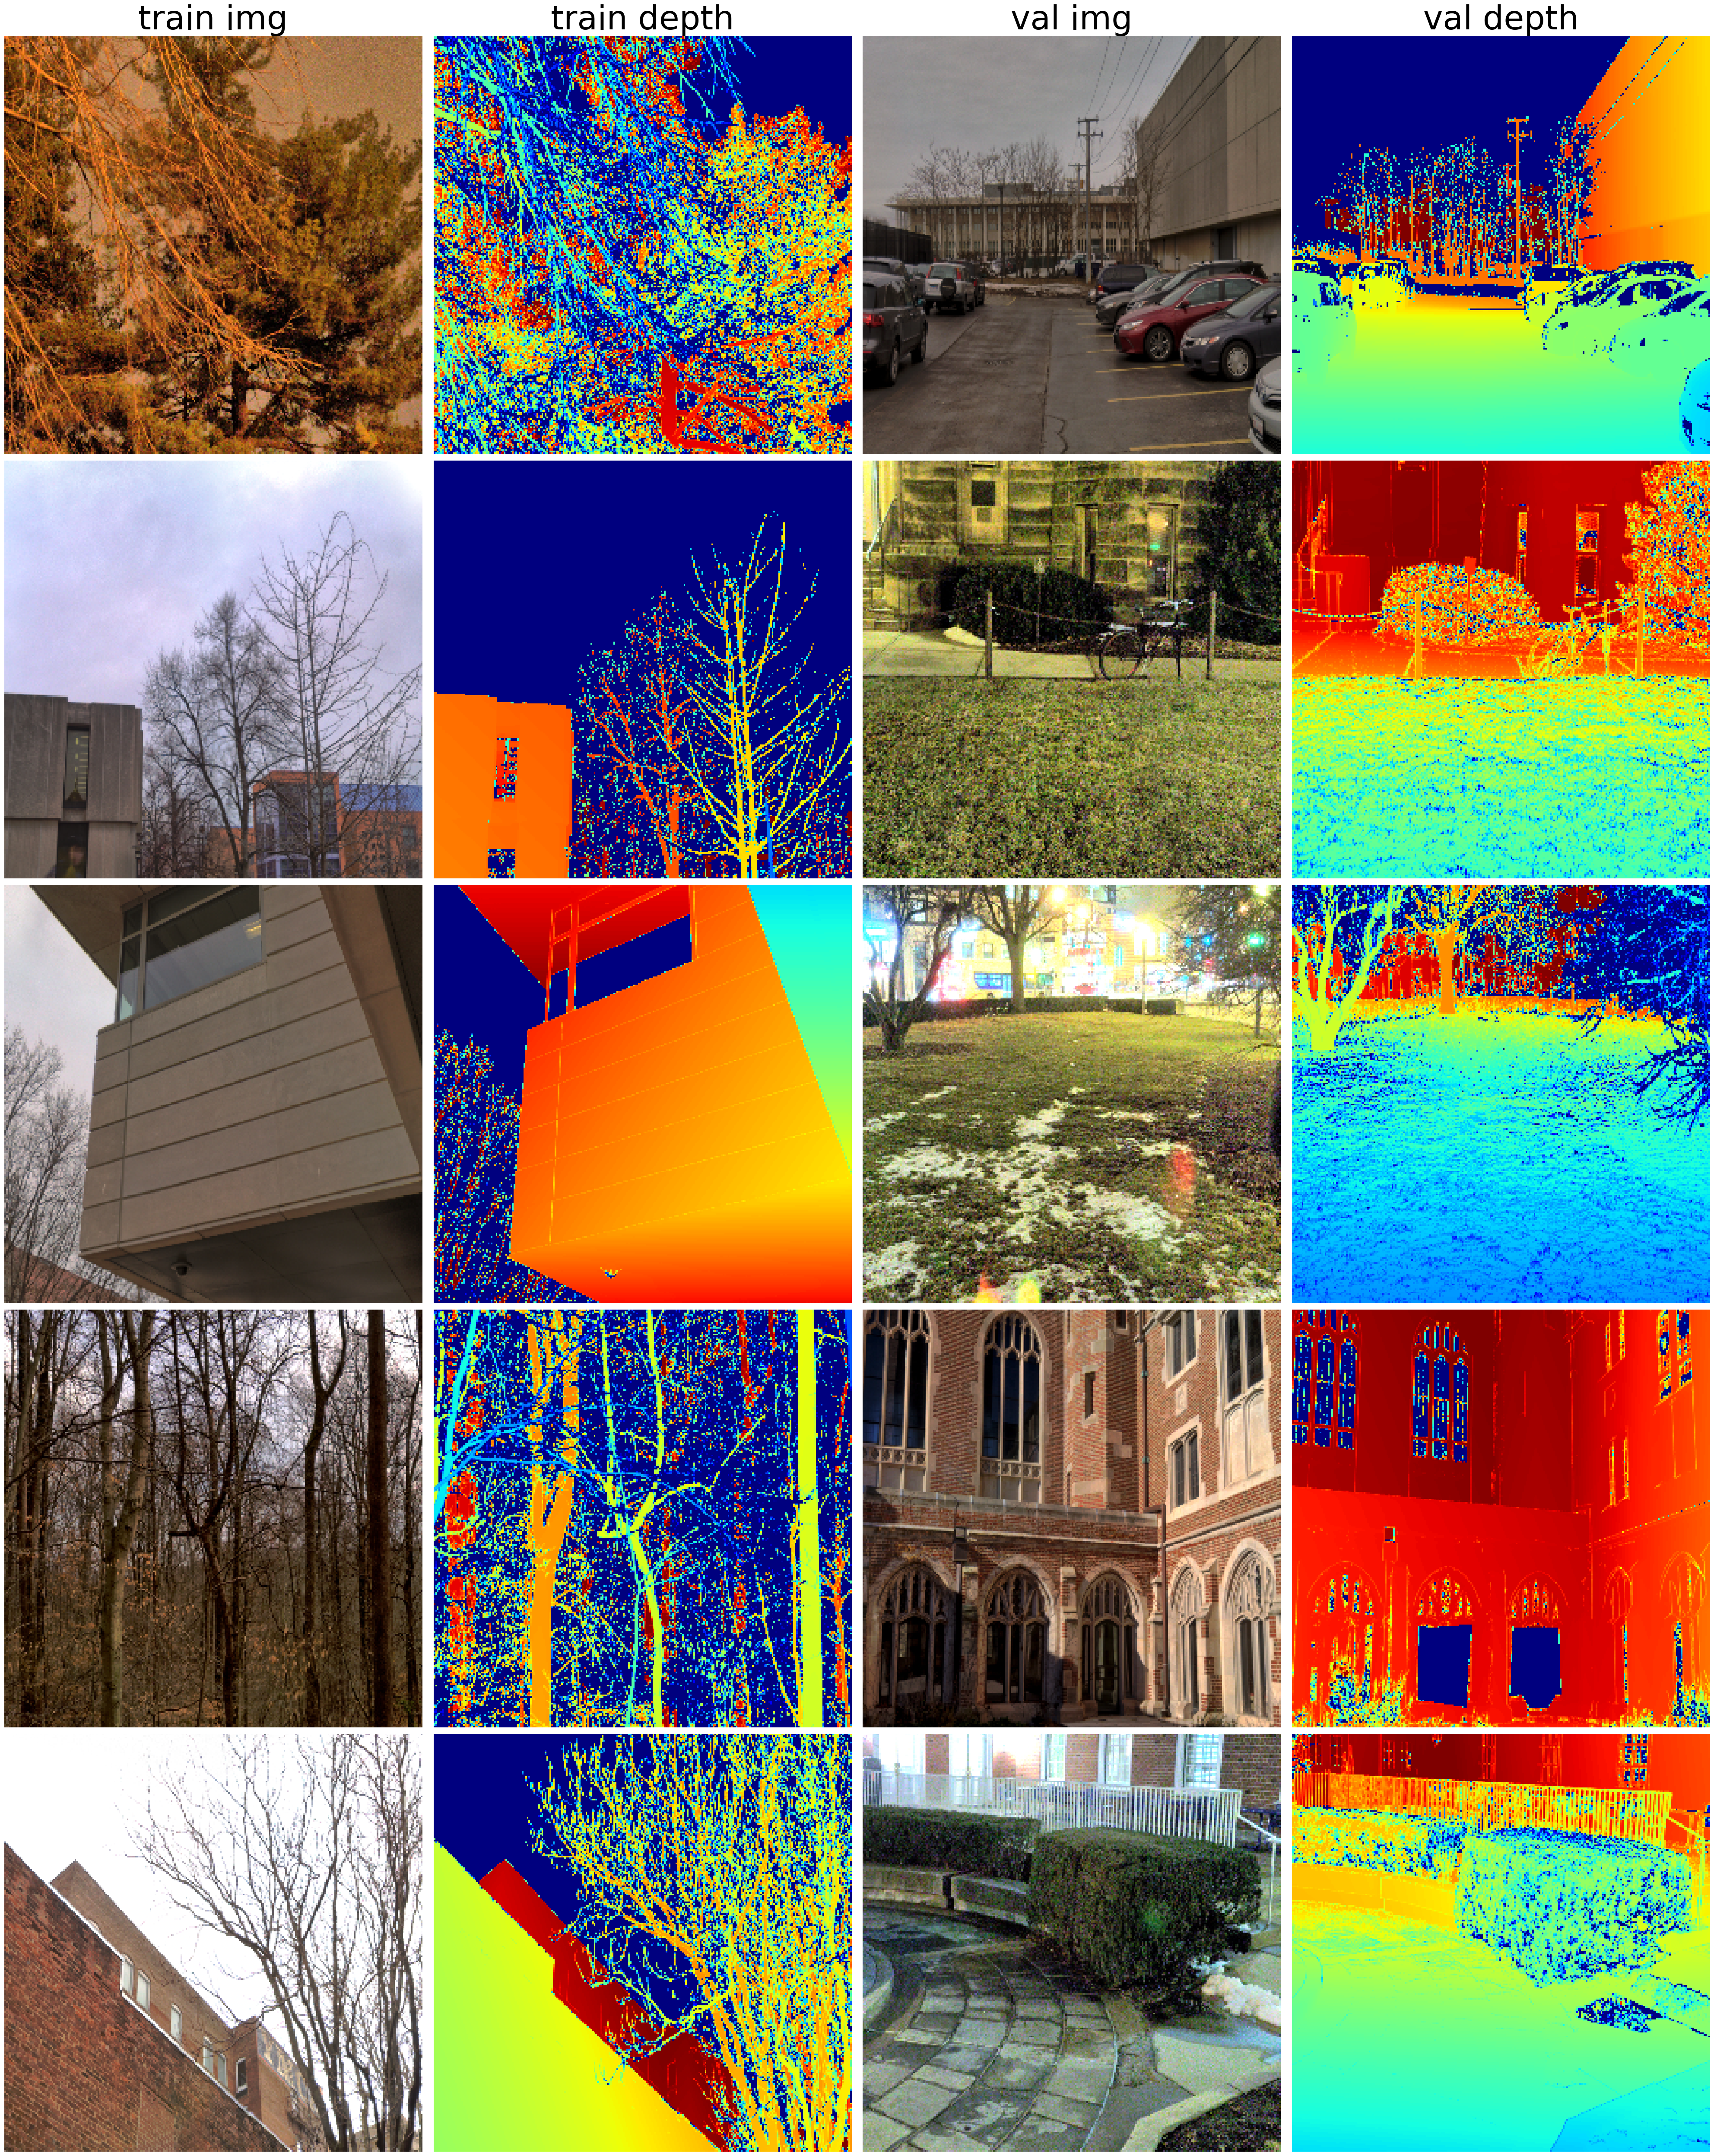

In [5]:
# prepare the dataset
os.chdir('D:\\Informatics\\Μεταπτυχιακό\\Εξάμηνο Γ\\dataset')

train = pd.read_csv('train_outdoor.csv')
train = train.drop(train.columns[[3]], axis=1)
train.columns = ['image', 'depth', 'mask']
train = train.sample(frac=1)

val = pd.read_csv('val_outdoor.csv')
val = val.drop(val.columns[[3]], axis=1)
val.columns = ['image', 'depth', 'mask']
val = val.sample(frac=1)

# visualize the samples
visualize_train = next(iter(DataGenerator(data=train, batch_size=6, dim=(256, 256))))
visualize_val = next(iter(DataGenerator(data=val, batch_size=6, dim=(256, 256))))
visualize_depth_map(visualize_train, visualize_val)

#### Show BANet results

In [3]:
def visualize_depth_map(samples, test=False, model=None):
    input, target = samples
    cmap = plt.cm.jet
    cmap.set_bad(color="black")

    if test:
        pred = model.predict(input)
        fig, ax = plt.subplots(6, 3, figsize=(50, 50))
        for i in range(6):
            ax[i, 0].imshow((input[i].squeeze()))
            ax[i, 1].imshow((target[i].squeeze()), cmap=cmap)
            ax[i, 2].imshow((pred[i].squeeze()), cmap=cmap)

    else:
        fig, ax = plt.subplots(6, 2, figsize=(50, 50))
        for i in range(6):
            ax[i, 0].imshow((input[i].squeeze()))
            ax[i, 1].imshow((target[i].squeeze()), cmap=cmap)

In [ ]:
# prepare the dataset
os.chdir('D:\\Informatics\\Μεταπτυχιακό\\Εξάμηνο Γ\\dataset')

val = pd.read_csv('val_outdoor.csv')
val = val.drop(val.columns[[3]], axis=1)
val.columns = ['image', 'depth', 'mask']
val = val.sample(frac=1)

os.chdir('C:\\Users\\StarWars\\Documents\\GitHub\\MSc_Thesis\\banet-depth-prediction\\models')
model = torch.load('load/from/path/model.pt')

test_loader = next(iter(DataGenerator(data=val[265:].reset_index(drop="true"), batch_size=6, dim=(256, 256))))

# visualize_depth_map(test_loader, test=True, model=model)

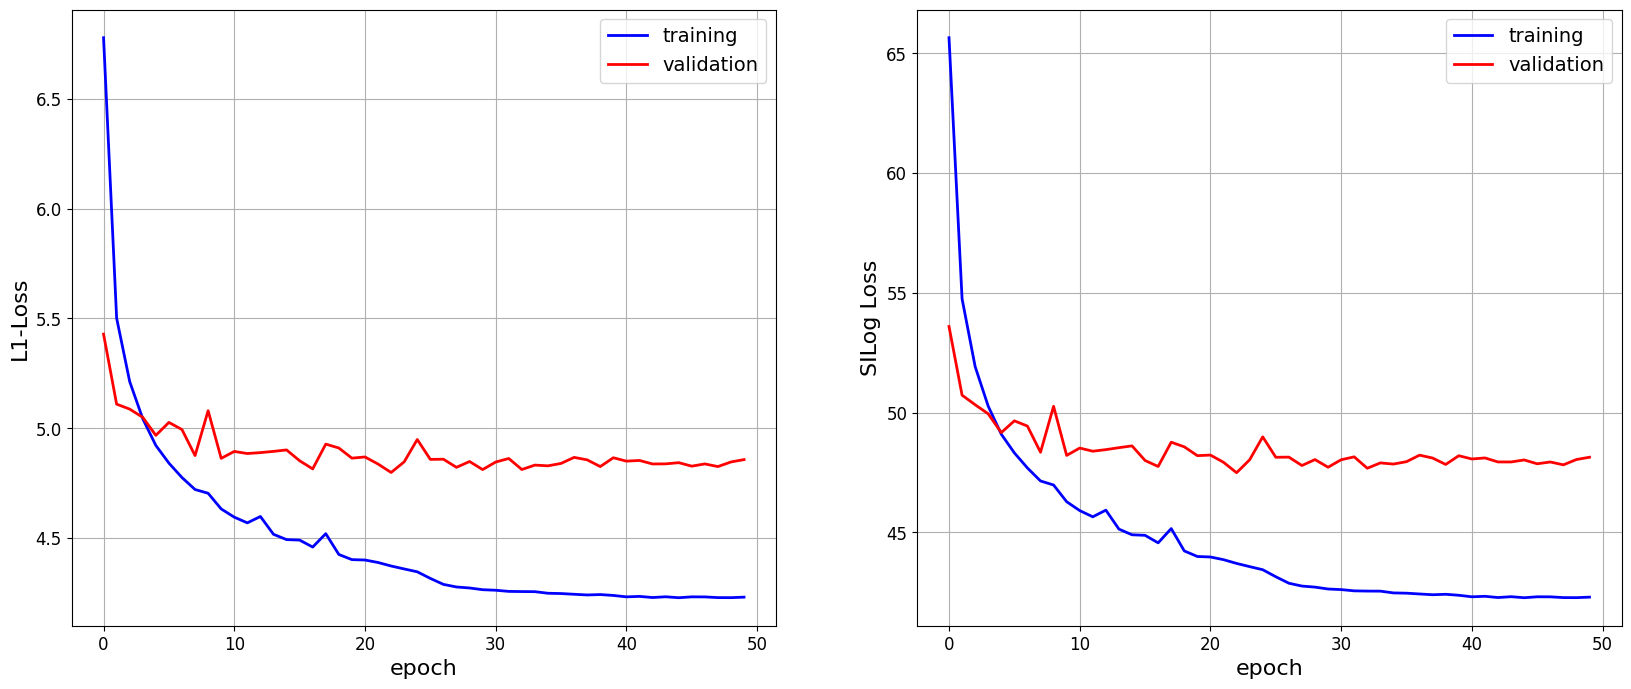

In [29]:
# prepare metrics dataframe
os.chdir('C:\\Users\\StarWars\\Documents\\GitHub\\MSc_Thesis\\banet-depth-prediction')
metrics = pd.read_csv('tmetrics.csv')

# show the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

# Plot validation L1-Loss
ax1.plot(metrics['Train Loss'], 'b', linewidth=2)
ax1.plot(metrics['Test Loss'], 'r', linewidth=2)
ax1.legend(['training', 'validation'], fontsize=14)
ax1.set_xlabel('epoch', fontsize=16)
ax1.set_ylabel('L1-Loss', fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.grid()

# Plot validation SILog Loss
ax2.plot(metrics['Train SILog'], 'b', linewidth=2)
ax2.plot(metrics['Test SILog'], 'r', linewidth=2)
ax2.legend(['training', 'validation'], fontsize=14)
ax2.set_xlabel('epoch', fontsize=16)
ax2.set_ylabel('SILog Loss', fontsize=16)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.grid()